In [3]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree

import tqdm
from matplotlib import pyplot as plt


In [4]:
datadir = '../../datasets/foldtree2/'

In [5]:

#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )


reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [6]:
repdirs = '../../datasets/foldtree2/struct_align/'

In [7]:
mkdirs = False
if mkdirs == True:
    #make a structure alignment directory
    if not os.path.exists( 'struct_align' ):
        os.makedirs( 'struct_align' )
    
    #make a directory for each cluster representative
    for rep in reps['repId']:
        if not os.path.exists( datadir +'struct_align/' + rep  ):
            os.makedirs(datadir + 'struct_align/' + rep  )
        if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
            os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
            

In [8]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
    n = 5
    for rep in tqdm.tqdm(reps.repId.unique() ):
        subdf = reps[ reps['repId'] == rep ]
        if len(subdf) < n:
            n = len(subdf)
        subdf = subdf.sample( n = n  )
        subdf = subdf.head( n )
        #download the structures
        for uniID in subdf['entryId']:
            AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [9]:
#for each folder in struct_align, align the structures with all vs all using foldseek
from src import foldseek2tree
aln_structs = False
if aln_structs == True:
    for rep in tqdm.tqdm(reps.repId.unique() ):
        #align the structures
        foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [141]:
import foldtree2_ecddcd as ft2
import torch
#get all example structures in a directory
structs = glob.glob('families/fsx1/*.pdb')
print(structs)

ndim = 844
converter = ft2.PDB2PyG()

#with open( 'model.pkl' , 'rb' ) as f:
#    encoder,decoder = pickle.load( f )


with open( './encoder_mk3_aa_EMA_64_lowcost_model.pkl' , 'rb' ) as f:
    encoder,decoder = pickle.load( f )

alphabetsize = encoder.vector_quantizer.embedding_dim

#use the encoder to make a fasta file
#encoder = ft2.HeteroGAE_Encoder(in_channels=ndim, hidden_channels=[ 400 ]*3 , out_channels=250, metadata=converter.metadata , num_embeddings=248, commitment_cost=1 , encoder_hidden=500 , EMA = True , reset_codes = False )
#encoder_save = 'encoder_mk2_aa_50_AAq_transformermk3_248'
#encoder.load_state_dict( torch.load( encoder_save ) )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = encoder.to(device)
encoder.eval()


['families/fsx1/6EGU.pdb', 'families/fsx1/5mf1mono.pdb', 'families/fsx1/WP_163487151_Hborinquense.pdb', 'families/fsx1/4GSX.pdb', 'families/fsx1/WP_007110832_Naltunense.pdb', 'families/fsx1/4OJC_model.pdb', 'families/fsx1/2ala.pdb', 'families/fsx1/1OAN.pdb', 'families/fsx1/2I69.pdb', 'families/fsx1/6E18.pdb', 'families/fsx1/WP_049937247_Hnatans.pdb', 'families/fsx1/3n43.pdb', 'families/fsx1/5ow3.pdb', 'families/fsx1/WP_058826362_Haloferax.pdb', 'families/fsx1/1SVB.pdb', 'families/fsx1/fsxA11_monomer.pdb', 'families/fsx1/1rer.pdb', 'families/fsx1/4HJ1.pdb']


HeteroGAE_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_backbone_res): SAGEConv(844, 400, aggr=mean)
      (res_backbonerev_res): SAGEConv(844, 400, aggr=mean)
      (res_contactPoints_res): SAGEConv(844, 400, aggr=mean)
      (res_hbond_res): SAGEConv(844, 400, aggr=mean)
    )
    (1-2): 2 x ModuleDict(
      (res_backbone_res): SAGEConv(400, 400, aggr=mean)
      (res_backbonerev_res): SAGEConv(400, 400, aggr=mean)
      (res_contactPoints_res): SAGEConv(400, 400, aggr=mean)
      (res_hbond_res): SAGEConv(400, 400, aggr=mean)
    )
  )
  (bn): BatchNorm1d(844, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (out_dense): Sequential(
    (0): Linear(in_features=420, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): Tanh()
  )
  (vector_quantizer): VectorQuantizerE

In [143]:

import importlib
importlib.reload(ft2)
from torch_geometric.data import DataLoader

struct_dat = ft2.StructureDataset('structs_structalign_new.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encoder.eval()

encode_alns = True
if encode_alns == True:
        
    def databatch2list(loader):
        for data in loader:
            data = data.to_data_list()
            for d in data:
                yield d
    encoder_loader = databatch2list(encoder_loader)
    encoder.encode_structures_fasta(encoder_loader , 'aln_encoded.fasta' )

12530it [04:40, 44.63it/s]


In [144]:
encoded_fasta = '/home/dmoi/projects/foldtree2/aln_encoded.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    for line in tqdm.tqdm(f):
        if line[0] == '>' and line[-1] == '\n':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )
print(encoded_df)

25060it [00:00, 375067.38it/s]

                                                          seq
protid                                                       
A0A2D6SQL2  @;7,;(!þ.7@9+@+@7þ...
A0A654I0W9  9$(,(þ@ù@9,...
A0A7J9N1H0  &(ú9&$&+ü.@?,+...
A0A2S8RXS2  (&@9@,;ù;þ?ù$ûû+ü!,+...
A0A5N1JUQ3  ,797(,+7+@þ(þ...
...                                                       ...
A0A182SPG3  @,þ444444444?44þ(,7$@...
A0A453GYB2  9!+.&ú(&$++;,!+&(...
A0A0K1EBN6  9@99+7ù$@@47ü7@ù,;(...
A0A5C3N291  9ù@44,4444@@(;@&,9ü...
A0A0D6LI03  77@?ù,;ù+$&\tü!9...

[12529 rows x 1 columns]


In [145]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary
#z is not used currently...

replace_dict = { '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) , '"':chr(248) , '#':chr(247) }

In [146]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq
protid                                                       
A0A2D6SQL2  @;7,;(!þ.7@9+@+@7þ...
A0A654I0W9  9$(,(þ@ù@9,...
A0A7J9N1H0  &(ú9&$&+ü.@?,+...
A0A2S8RXS2  (&@9@,;ù;þ?ù$ûû+ü!,+...
A0A5N1JUQ3  ,797(,+7+@þ(þ...
...                                                       ...
A0A182SPG3  @,þ444444444?44þ(,7$@...
A0A453GYB2  9!+.&ú(&$++;,!+&(...
A0A0K1EBN6  9@99+7ù$@@47ü7@ù,;(...
A0A5C3N291  9ù@44,4444@@(;@&,9ü...
A0A0D6LI03  77@?ù,;ù+$&\tü!9...

[12529 rows x 1 columns]


In [147]:
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )
print(encoded_df.head())

                                                          seq  \
protid                                                          
A0A2D6SQL2  @;7,;(!þ.7@9+@+@7þ...   
A0A654I0W9  9$(,(þ@ù@9,...   
A0A7J9N1H0  &(ú9&$&+ü.@?,+...   
A0A2S8RXS2  (&@9@,;ù;þ?ù$ûû+ü!,+...   
A0A5N1JUQ3  ,797(,+7+@þ(þ...   

                                                          ord  \
protid                                                          
A0A2D6SQL2  [1, 1, 15, 64, 59, 55, 44, 59, 40, 22, 18, 33,...   
A0A654I0W9  [1, 1, 25, 57, 28, 15, 25, 25, 36, 4, 4, 18, 2...   
A0A7J9N1H0  [1, 1, 15, 18, 1, 20, 17, 27, 22, 38, 28, 22, ...   
A0A2S8RXS2  [1, 1, 40, 18, 12, 16, 38, 15, 22, 22, 18, 15,...   
A0A5N1JUQ3  [1, 1, 44, 27, 8, 12, 55, 22, 12, 57, 55, 40, ...   

                                                         hex2  
protid                            

In [148]:
#find union of all sets of characters for sequences
char_set = set()
for seq in encoded_df.seq:
    char_set = char_set.union( set( seq ) )
char_set = list( char_set )
char_set.sort()
print( char_set )
print( len(char_set) )


['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', '!', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ']
64


In [149]:

cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')

fident_thresh = .3

submat =  np.zeros((256,256))

background_freq = np.zeros(len(char_set))

q_mat = np.zeros((256,256))

seqcount = 0
for rep in tqdm.tqdm(alnfiles ):

    q_mat_chunk = np.zeros((256,256))
    submat_chunk = np.zeros((256,256))
    alncount = 0
    #load the all vs all aln
    aln_df = pd.read_table(rep)
    aln_df.columns = cols
    #load the embedding of the structures
    q = aln_df['query'].unique()
    t = aln_df['target'].unique()
    
    seqset = set()
    representative = rep.split('/')[-2]
    for q in aln_df['query'].unique():
        for t in aln_df['target'].unique():
            if q != t:
                #align the structures
                aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
                if len(aln)> 0 and aln.fident.iloc[0] < fident_thresh:
                    aln = aln.iloc[0]
                    qaln = aln.qaln
                    taln = aln.taln
                    qaccession = q.split( '.' )[0]
                    taccession = t.split( '.' )[0]

                    if qaccession in encoded_df.index and taccession in encoded_df.index:
                        qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
                        tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])

                        if qaccession not in seqset:
                            background_freq += np.array([ qz.count( c ) for c in char_set ])
                            seqset.add( qaccession )
                            seqcount += len(qz)
                        
                        if len( qz) == len( qaln.replace('-','') ) and len( tz) == len( taln.replace('-','') ):
                            qz = iter(qz)
                            tz = iter(tz)

                            #transfer the alignments to the embeddings                    
                            qaln_ft2, taln_ft2 = [], []

                            for q_char in qaln:
                                if q_char == '-':
                                    qaln_ft2.append(None)
                                else:
                                    qaln_ft2.append(ord(next(qz)))
                                   
                            for t_char in taln.strip():
                                if t_char == '-':
                                    taln_ft2.append(None)
                                else:
                                    taln_ft2.append(ord(next(tz)))

                            alnzip = list(zip( qaln_ft2 , taln_ft2 ))
                            alnzip = np.array([ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None])
                            #normalize by size of alignment
                            
                            submat_chunk[alnzip[:,0] , alnzip[:,1]] += 1
                            #normalize by size of alignment and number of pairs
                            alncount += 1
                            q_mat_chunk[alnzip[:,0] , alnzip[:,1]] += 1 / len(qaln.replace('-',''))
        if alncount > 0:
            q_mat += (q_mat_chunk / alncount)
            submat += (submat_chunk / alncount)



100%|████████████████████████████████████████████████████████████████████████████| 3691/3691 [00:46<00:00, 79.90it/s]


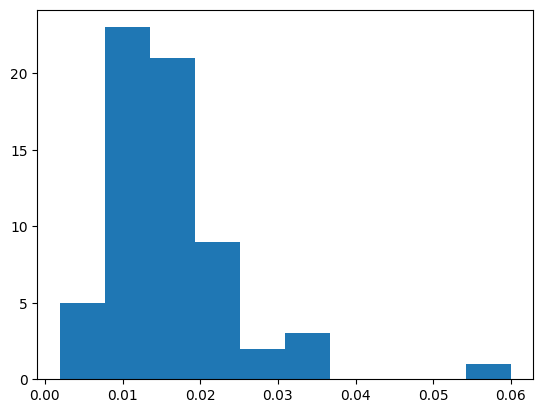

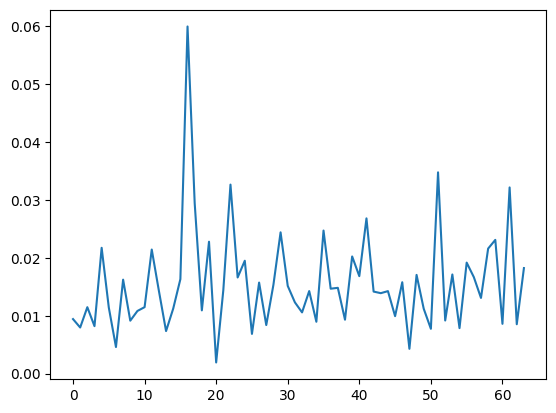

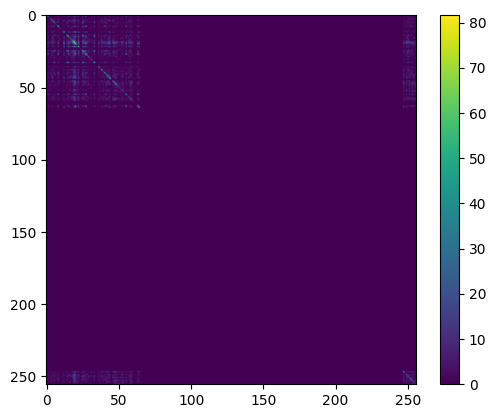

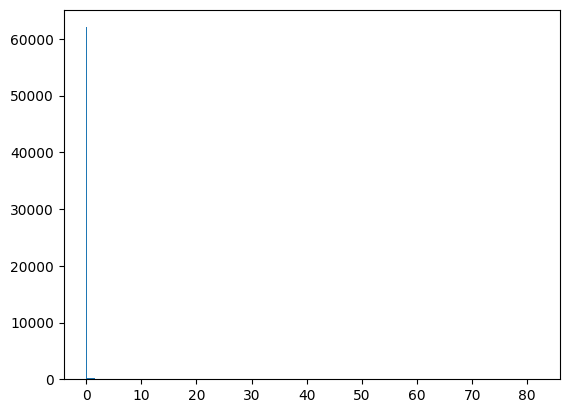

In [150]:
background_freq = background_freq / np.sum( background_freq )
q_mat = q_mat + q_mat.T
plt.hist( background_freq )
plt.show()
plt.plot( background_freq )
plt.show()

#ploT QMAT
plt.imshow(q_mat)
plt.colorbar()
plt.show()
plt.hist(q_mat.flatten() , bins = 400)
plt.show()


In [178]:
print( len(background_freq))

64


In [179]:
#normalize qmat so that each row and column sums to 1


np.fill_diagonal(q_mat, 0 )


for i in range(256):
    if np.sum( q_mat[i,:] ) > 0:
        q_mat[i,:] = q_mat[i,:] / np.sum( q_mat[i,:] )
        q_mat[:,i] = q_mat[i,:]
    else:
        q_mat[i,i] = 1
        q_mat[i,i] = 1


In [180]:
alphabet = [ord(c) for c in char_set]
sub_qmat = q_mat[alphabet,:]
sub_qmat = sub_qmat[:,alphabet]


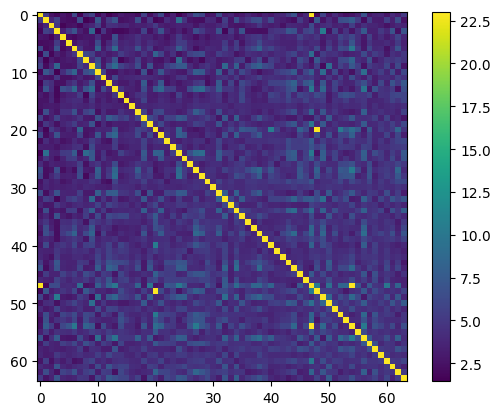

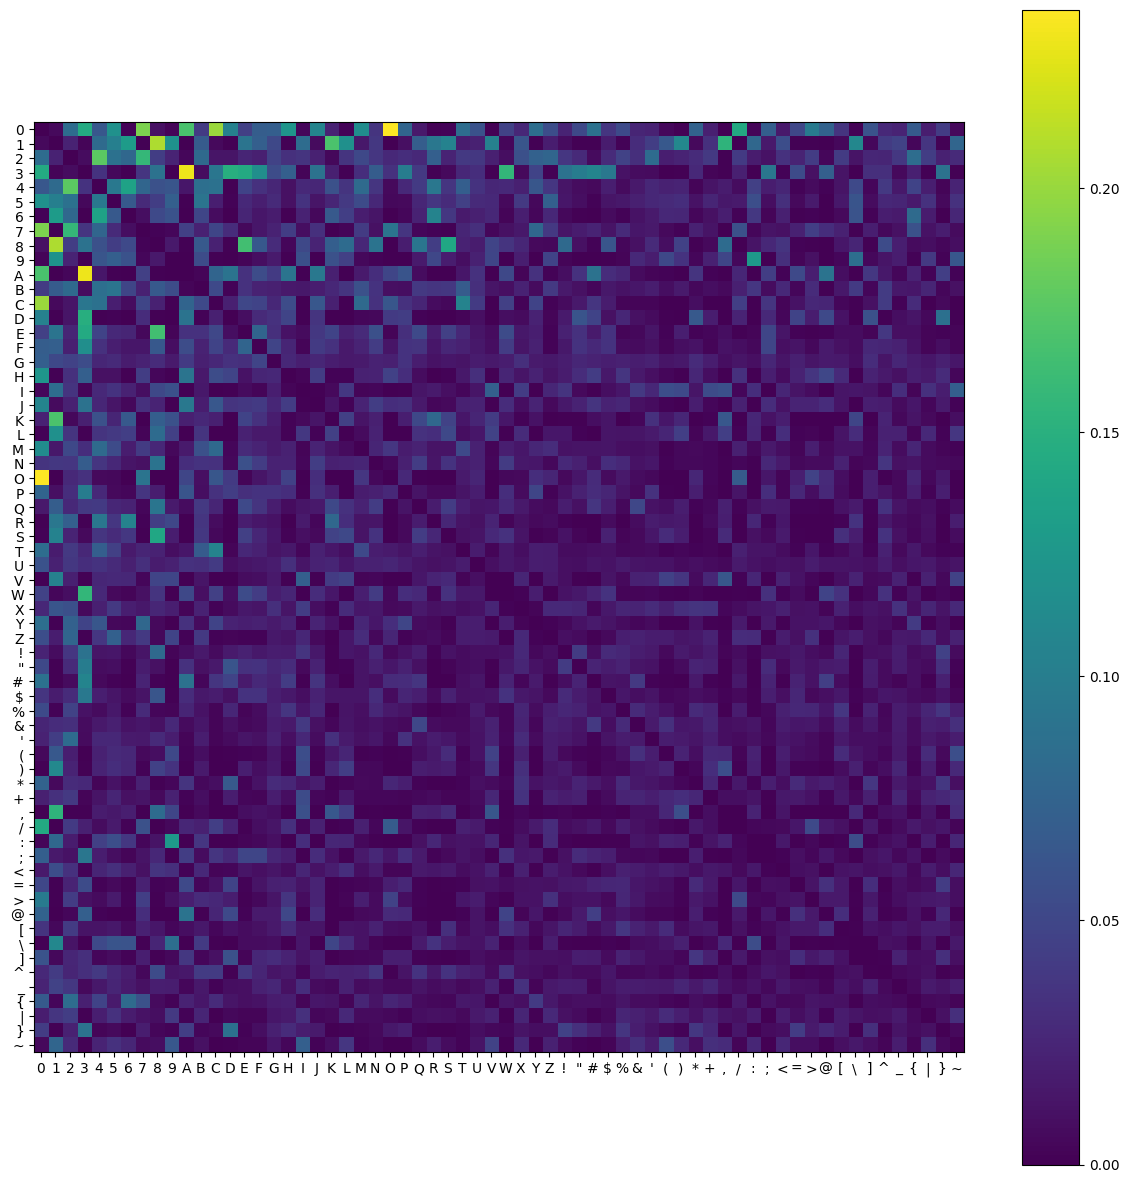

In [186]:
#divide the columns of qmat by the sum of the column

plt.imshow(-np.log(sub_qmat+10**-10))
plt.colorbar()
plt.show()
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()

plt.figure( figsize=(15,15))

plt.imshow(sub_qmat)
#make tick marks alphabet
plt.xticks( range(len(inputchars)), inputchars)
plt.yticks( range(len(inputchars)), inputchars)
plt.colorbar()
plt.show()

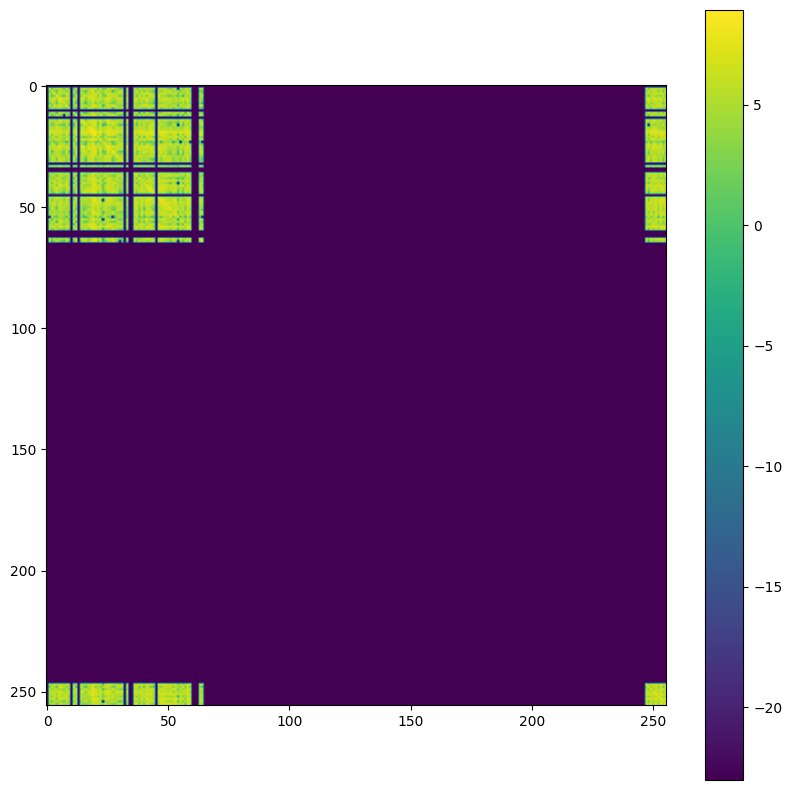

(array([6.1456e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 3.0000e+00, 2.1000e+01, 8.9000e+01,
        2.7600e+02, 5.1400e+02, 1.3650e+03, 1.6810e+03, 1.3000e+02]),
 array([-23.02585093, -21.42737446, -19.828898  , -18.23042153,
        -16.63194507, -15.0334686 , -13.43499213, -11.83651567,
        -10.2380392 ,  -8.63956274,  -7.04108627,  -5.44260981,
         -3.84413334,  -2.24565687,  -0.64718041,   0.95129606,
          2.54977252,   4.14824899,   5.74672545,   7.34520192,
          8.94367839]),
 <BarContainer object of 20 artists>)

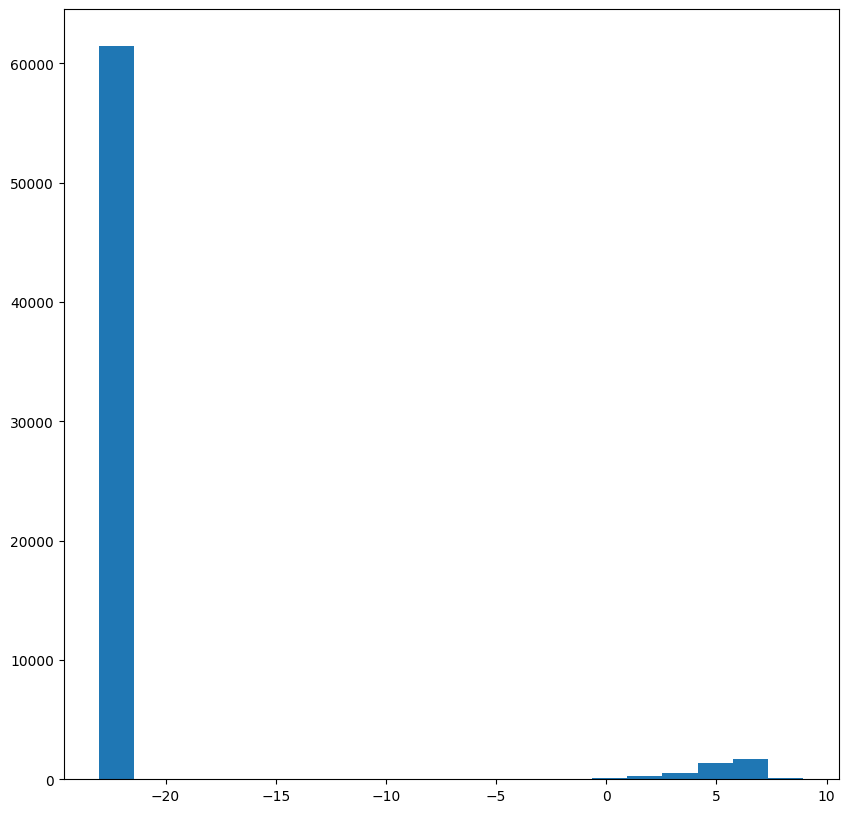

In [188]:
plt.figure( figsize=(10,10))
plt.imshow(np.log(submat + 10**-10 ) )
plt.colorbar()

plt.show()
plt.figure( figsize=(10,10))

plt.hist( np.log( submat.flatten() + 10 **-10 )  , bins = 20)

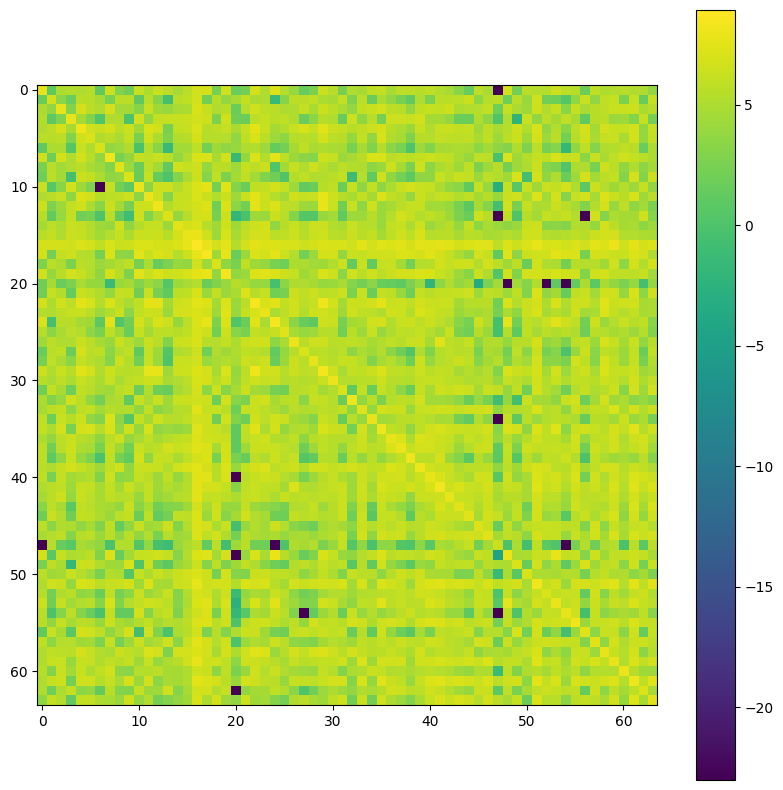

In [189]:
#remove zero rows and columns for visualization

vismat = submat[alphabet, : ]
vismat = vismat[ :, alphabet ]

plt.figure( figsize=(10,10))
plt.imshow(np.log(vismat + 10**-10 ) )
plt.colorbar()


In [190]:
#mafft matrix file example max 248 char
"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def formathex(hexnum):
    if len(hexnum) == 3:
        return hexnum[0:2] + '0' + hexnum[2]
    else:
        return hexnum

def output_mafft_matrix( submat , outpath='mafft_submat.mtx' ):
    with open(outpath, 'w') as f:
        for i in range(submat.shape[0]):
            for j in range(submat.shape[1]):
                if i <= j:
                    
                    stringi = chr(i)
                    stringj = chr(j)
                    
                    if stringi in replace_dict.keys():
                        stringi = replace_dict[stringi]
                    if stringj in replace_dict.keys():
                        stringj = replace_dict[stringj]
                    
                    i = ord(stringi)
                    j = ord(stringj)

                    hexi = formathex(hex(i))
                    hexj = formathex(hex(j))
                    
                    if submat[i,j] > 1:
                        f.write( f'{hexi} {hexj} {submat[i,j]} \n ')# '+ stringi + 'x' + stringj + ' \n' )
                    #else:
                    #    f.write( f'{hexi} {hexj} {0.0} # '+ stringi + 'x' + stringj + ' \n' )
output_mafft_matrix( submat , outpath='mafft_submat.mtx' )


In [191]:
#align the structures
# mafft --textmatrix maff_submat.mtx input > output

In [192]:
import subprocess
import Bio.PDB as PDB
def run_mafft_textaln( infasta , outaln , matrix='mafft_submat.mtx' ):
    cmd = f'mafft --text --localpair --maxiterate 1000 --textmatrix {matrix} {infasta}  > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def mafft_hex2fasta( intext , outfasta ):
    #% /usr/local/libexec/mafft/hex2maffttext input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/hex2maffttext {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    


def fasta2hex( intext , outfasta ):
    #% /usr/local/libexec/mafft/maffttext2hex input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/maffttext2hex {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    

def normal_mafft( infasta , outaln ):
    cmd = f'mafft --anysymbol {infasta} > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln



def struct2sequence(structfile):
    parser = PDB.PDBParser()
    structure = parser.get_structure('struct', structfile)
    seq = ''
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    seq += residue.get_resname()
    return seq

In [193]:
import glob
structs = glob.glob('families/fsx1/*.pdb')


In [194]:
#make normal fasta

with open( 'fsx1_example.fasta', 'w') as f:
    for s in structs:
        seq =  struct2sequence(s)
        if len(seq)>0:
            identifier = s.split('/')[-1].split('.')[0]
            f.write('>' + identifier + '\n' + seq + '\n')


In [195]:

def loader( structlist , converter):
    for struct in tqdm.tqdm(structlist):
        try:
            data = converter.struct2pyg( struct )
            yield data
        except:
            print('error')
            continue

loader = loader( structs , converter )
encoder.encode_structures_fasta( loader , 'fsx1_encoded.fasta')


2it [00:01,  1.47it/s]

error


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.58it/s]
17it [00:11,  1.49it/s]


'fsx1_encoded.fasta'

In [196]:
aln = normal_mafft( 'fsx1_example.fasta' , 'fsx1_example.aln' )


mafft --anysymbol fsx1_example.fasta > fsx1_example.aln


inputfile = orig
17 x 2364 - 1152 p
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 1404 ambiguous characters.
    1 / 17
done.

Constructing a UPGMA tree (efffree=0) ... 
   10 / 17
done.

Progressive alignment 1/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5837
STEP    16 / 16 
done.

Making a distance matrix from msa.. 
    0 / 17
done.

Constructing a UPGMA tree (efffree=1) ... 
   10 / 17
done.

Progressive alignment 2/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5803
STEP    16 / 16 
done.

disttbfast (aa) Version 7.453
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scori

In [ ]:
#load alignment into dataframe
aln_data = {}
with open('fsx1_example.aln', 'r') as f:
    for line in f:
        if line[0] == '>':
            ID = line[1:].strip()
            aln_data[ID] = ''
        else:
            aln_data[ID] += line.strip()
normal_aln_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
print(normal_aln_df)
print(len(normal_aln_df.seq.iloc[0]))

                     protid                                                seq
0                      6EGU  ---------------CYSSERGLULEUILEGLNALASERSERARGI...
1                  5mf1mono  ---------VALILEALASERGL-YARGL--------------EUG...
2                      4GSX  ------------ARGCYSVALGLYILEGL---------YASNARGA...
3   WP_007110832_Naltunense  ---------------ILETHRGLUTYRTHR------SERASNSERG...
4                4OJC_model  --------------GLYPHEP-ROLEUGL---------------UG...
5                      2ala  ------------------TYRGL-UH--------------------...
6                      1OAN  ---------METARGCYSILEGLYILESE---------RASNARGA...
7                      2I69  ---------PHEASNCYSLEUGLYMETSE---------RASNARGA...
8                      6E18  ------GLUVALILEALASERGL-YARGL--------------EUG...
9      WP_049937247_Hnatans  ------------ALAALASER---TYRLYS------SERASNSERG...
10                     3n43  ------------GLYGLYTYRGL-UH--------------------...
11                     5ow3  ILEGLNILELEUSERLYSSERLY

: 

In [197]:
#convert fsx1_encoded.fasta to fsx1_encoded.hex
encoded_fasta = 'fsx1_encoded.fasta'
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    with open('fsx1_encoded.hex' , 'w') as g:
        for line in f:
            if line[0] == '>':
                g.write(line )
            else:
                hexstr = ''
                for char in line:
                    hexstr += formathex(hex(ord(char)))[2:] + ' '
                g.write(hexstr + '\n')

with open( 'fsx1_encoded.hex', 'r') as f:
    for line in f:
        print(line)

>6EGU

24 24 1a 11 19 21 39 fa 0c 0c 13 21 16 16 24 0c 16 16 12 24 13 19 1a 26 16 fa 19 21 13 fa 1f 1a 0e 26 fa 11 fa 24 19 06 19 12 26 0f 12 11 04 39 16 12 05 19 12 21 12 16 0f 1a 1a 11 19 1a 24 13 11 26 02 1a 1e 07 3a 1f 1a 05 1a 1d 12 24 19 1a 1a 13 13 24 31 19 0f 23 11 24 31 0f 2e 13 24 19 1a 07 13 09 2e 11 16 1a fa 11 05 1a 05 0e 23 2b 1a 16 16 06 13 11 2e 12 24 05 11 39 24 26 23 31 26 24 26 24 08 2e 0f 2e 1d 1a 24 19 05 0f 1c 16 28 19 39 1a 0f 13 12 11 fa 19 13 0f 05 2e 24 21 09 07 0f 1c 12 19 16 19 11 21 16 04 05 09 26 1a 0e 1a 16 21 09 19 1f fa 1a 1a 1a 13 05 3a 2e 07 1f 1a 0e 1a 19 1a 19 2a fa 11 1f 21 18 23 1a 2e 1a 05 1a 05 21 11 1a 1d 1f 12 1f 1e fa 21 0e 09 11 1d 05 1a 11 21 1d 13 02 1f 05 19 1f 11 21 13 24 2e 1a 11 1a 1a 0f 19 1a fa 1c 11 1a 24 19 13 fa 1d 2e 19 21 18 1e 12 1d 06 21 09 02 19 11 24 3a 3a 2e 19 21 09 1d 05 0e 0e 05 11 13 1f 1a 22 1d 02 3a 13 2e 09 12 3a 05 fa fa 18 12 1f 25 13 1f 0e 02 fa 05 1a 12 26 1a 0f 39 fa 09 19 16 19 01 05 04 2e 05 11 0f 04 05 0f 26 

In [198]:
#go to ascii encoding
hexfile = 'fsx1_encoded.hex'
asciifile = mafft_hex2fasta( hexfile , 'fsx1_encoded.ASCII' )

/usr/lib/mafft/lib/mafft/hex2maffttext fsx1_encoded.hex > fsx1_encoded.ASCII


In [199]:
#align wti mafft
run_mafft_textaln( asciifile , 'fsx1_econded.aln.ascii' , matrix='mafft_submat.mtx' )

mafft --text --localpair --maxiterate 1000 --textmatrix mafft_submat.mtx fsx1_encoded.ASCII  > fsx1_econded.aln.ascii


outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
Score(=0x1,=0x1)=2512.882059
Score(=0x1,=0x2)=2.728780
Score(=0x1,=0x3)=144.810605
Score(=0x1,=0x4)=188.202929
Score(=0x1,=0x5)=166.362110
Score(=0x1,=0x6)=253.054225
Score(=0x1,=0x7)=3.240894
Score(=0x1=0x8)=710.752240
Score(=0x1,	=0x9)=16.945933
Score(=0x1,�=0xff)=41.453717
Score(=0x1,=0xb)=7.234631
Score(=0x1,=0xc)=506.777639
Score(=0x1,�=0xfe)=175.776467
Score(=0x1,=0xe)=141.359049
Score(=0x1,=0xf)=607.402512
Score(=0x1,=0x10)=289.077133
Score(=0x1,=0x11)=110.138445
Score(=0x1,=0x12)=266.588796
Score(=0x1,=0x13)=887.410213
Score(=0x1,=0x14)=1024.496132
Score(=0x1,=0x15)=11.444615
Score(=0x1,=0x16)=782.082569
Score(=0x1,=0x17)=5.018775
Score(=0x1,=0x18)=8.108389
Score(=0x1,=0x19)=977.836986
Score(=0x1,=0x1a)=162.276819
Score(=0x1,=0x1b)=1460.151593
Score(=0x1,=0x1c)=209.793291
Score(=0x1,=0x1d)=54.080152
Score(=0x1,=0x1e)=4.342873
Score(=0x1,=0x1f)=

'fsx1_econded.aln.ascii'

In [200]:
#change from mafft text 2 hex
aln_hexfile = fasta2hex( 'fsx1_econded.aln.ascii' , 'fsx1_encoded.aln.hex' )


/usr/lib/mafft/lib/mafft/maffttext2hex fsx1_econded.aln.ascii > fsx1_encoded.aln.hex


In [201]:

with open( aln_hexfile , 'r') as f:
    for l in f:
        print(l)

>6EGU

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 24 24 1a 11 -- 19 21 39 fa 0c 0c 13 21 16 16 24 0c 16 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

16 12 24 13 19 1a 26 16 fa 19 21 13 fa 1f 1a -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 0e 26 fa 11 fa 24 19 06 19 12 26 0f -- -- -- -- -- -- -- -- 12 11 04 39 16 12 -- -- -- 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 05 19 12 21 12 16 0f 1a 1a 11 19 1a 24 13 11 26 02 1a 1e 07 3a 1f 1a 05 1a 1d 12 24 19 1a 1a -- -- -- -- 13 -- -- -- -- -- -- -- -- -- 

-- -- -- 13 24 31 19 0f 23 11 24 31 0f 2e 13 24 19 1a 07 -- -- -- -- -- 13 09 2e -- -- 11 16 1a fa 11 05 1a 05 0e 23 2b 1a -- -- -- -- -- -- -- -- -- -- -- -- -- -- 16 16 06 13 11 

2e 12 24 05 11 39 24 26 23 31 -- -- -- -- -- -- 26 24 26 24 08 2e 0f 2e 1d 1a 24 19 05 0f 1c -- -- -- -- -- -- -- -- -- 16 28 19 39 1a 0f 13 12 11 fa 19 13 0f 05 2e 24 21 09 07 0f 

1c 12 19 16 19 11 21 -- -- -- -- -- -- -- -- -- -- -- 16 04 05 09 -- -- -- -- -- --

In [202]:
#read the aln hex file
with open( aln_hexfile , 'r') as f:
    seqdict = {}
    seqstr = ''
    ID = ''
    for line in f:
        if line[0] == '>':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line + ' '
    seqdict[ID] = seqstr
alndf = pd.DataFrame( seqdict.items() , columns=['protid', 'hex_aln'] )
alndf.index = alndf.protid
alndf.drop( 'protid' , axis = 1 , inplace = True)
alndf.drop( ''  , inplace = True)
alndf['ord_aln'] = alndf.hex_aln.map( lambda x: [ int(c,16) if c!='--' else '-' for c in x.split() ] )
alndf['seq_aln'] = alndf.ord_aln.map( lambda x: ''.join([ chr(c) if c !='-' else '-' for c in x ]) )
print(alndf)

                                                                   hex_aln  \
protid                                                                       
6EGU                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
5mf1mono                 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
4GSX                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
WP_007110832_Naltunense  21 21 16 11 28 16 0c 2e 0c 11 08 08 04 26 -- -...   
4OJC_model               -- -- 40 40 08 2c 1b -- 10 11 12 08 04 26 1b 0...   
2ala                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
1OAN                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
2I69                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
6E18                     11 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
WP_049937247_Hnatans     fa fa fa 0c 28 12 0c 2e 0c 11 08 08 04 26 -- -...   
3n43                     -- -- -- -- -- -- -- -- -- -- -- -- -- 

In [203]:
#re-encode to 72 char
remap = { c:i for i,c in enumerate(char_set)}
print(remap)

{'\x01': 0, '\x02': 1, '\x03': 2, '\x04': 3, '\x05': 4, '\x06': 5, '\x07': 6, '\x08': 7, '\t': 8, '\x0b': 9, '\x0c': 10, '\x0e': 11, '\x0f': 12, '\x10': 13, '\x11': 14, '\x12': 15, '\x13': 16, '\x14': 17, '\x15': 18, '\x16': 19, '\x17': 20, '\x18': 21, '\x19': 22, '\x1a': 23, '\x1b': 24, '\x1c': 25, '\x1d': 26, '\x1e': 27, '\x1f': 28, '!': 29, '$': 30, '%': 31, '&': 32, "'": 33, '(': 34, ')': 35, '*': 36, '+': 37, ',': 38, '.': 39, '/': 40, '0': 41, '1': 42, '2': 43, '3': 44, '4': 45, '5': 46, '6': 47, '7': 48, '8': 49, '9': 50, ':': 51, ';': 52, '?': 53, '@': 54, '÷': 55, 'ø': 56, 'ù': 57, 'ú': 58, 'û': 59, 'ü': 60, 'ý': 61, 'þ': 62, 'ÿ': 63}


In [204]:
alndf['remap_int'] = alndf.seq_aln.map(lambda x : [ remap[c] if c in remap else '-' for c in x ] )

#NEXUS

inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~"""

symbols = {i:s for i,s in enumerate( inputchars.split() ) }
print( len( symbols) )
alndf['remap_symbols'] = alndf['remap_int'].map( lambda x : ''.join([ symbols[c] if c in symbols else '-' for c in x ]) )
print(alndf.remap_symbols)

64
protid
6EGU                       ---------------------UUNE-MT;^AAGTJJUAJ-------...
5mf1mono                   --------------------------CCT^NWGMEFUCC3@CJ---...
4GSX                       ------------------------GKUCWTW$G34CEWMNW^J{--...
WP_007110832_Naltunense    TTJEYJA$AE773W------------EC4CT$RTW8G<J3FTP^ET...
4OJC_model                 --@@7#O-DEF73WO7G^EQQPUNF-JKTCGH;JA;=H0AATHG--...
2ala                       ----------------------RREPNJC5Q$CCW4QYF^PTEG&-...
1OAN                       ----------------------55G-UTWTA$G34CEWCAWWN{--...
2I69                       ----------------------44$-UMW0A$G34MEWCAW^J{--...
6E18                       E-------------------------ECT^NWGMEFUCC3WCJ---...
WP_049937247_Hnatans       ^^^AYFA$AE773W------------ECM;^WRBN$4^J3FT$CPM...
3n43                       -------------W-------SSYEPCJCTQ$JCWCQYFJMC$GQ-...
5ow3                       TT------------------------;TMAFAFMEFUDFJA}A---...
WP_058826362_Haloferax     JJCJYEA$A3773W------------;CM;CWRJN$4^J

In [205]:
#output remap symbols column to fasta
with open('fsx1_encoded.aln.remap.fasta', 'w') as f:
    for i in alndf.index:
        f.write('>' + i + '\n' + alndf.loc[i].remap_symbols + '\n')


In [206]:

bg_raxml = np.zeros( len(inputchars.split()) )
sub_raxml = np.zeros(( len(inputchars.split()) , len(inputchars.split()) ))

bg_raxml[:len(char_set)] = background_freq
sub_raxml[:len(char_set),:len(char_set)] =  sub_qmat



In [207]:
def raxml_matrix( matrix, background_frequencies, outfile = "raxml_custom_matrix.txt"):
    # Create the substitution matrix file
    #lower triangular matrix
    with open(outfile, "w") as f:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[0]):
                if j < i:
                    #format to 6 decimal places
                    f.write(f" {matrix[i,j]:.6f}")
            f.write("\n")
        # Add the frequencies
        for i, freq in enumerate(background_frequencies):
            f.write(f"{freq:.6f} ")
        f.write("\n")
    return outfile

outmatrix = raxml_matrix( sub_qmat , background_freq,  outfile = "raxml_custom_matrix.txt")

with open('raxml_custom_matrix.txt', 'r') as f:
    for line in f:
        print(line)



 0.005729

 0.083293 0.022504

 0.144551 0.003678 0.007424

 0.064568 0.081473 0.176761 0.034251

 0.119606 0.101914 0.088067 0.005501 0.094820

 0.002140 0.129470 0.078824 0.000907 0.136108 0.065581

 0.189631 0.001736 0.157255 0.036670 0.077195 0.028496 0.008687

 0.010524 0.207788 0.042971 0.089366 0.058698 0.042508 0.052194 0.002233

 0.003324 0.120907 0.023700 0.000212 0.062728 0.071383 0.059271 0.003842 0.015775

 0.168106 0.000688 0.004106 0.230609 0.014266 0.001826 0.000206 0.044434 0.001279 0.000488

 0.041000 0.068047 0.080474 0.007604 0.086243 0.090673 0.049118 0.021258 0.066382 0.054718 0.003087

 0.201302 0.005685 0.013225 0.092638 0.088325 0.020302 0.007881 0.049273 0.021512 0.001273 0.076217 0.051905

 0.103672 0.000985 0.013596 0.148386 0.001209 0.002526 0.000165 0.029971 0.000927 0.000121 0.089974 0.002425 0.021044

 0.044757 0.091022 0.024661 0.144488 0.047744 0.027501 0.024416 0.004925 0.165063 0.002982 0.033958 0.033873 0.050529 0.009072

 0.069821 0.071756 0.0211

In [208]:
#raxml cmd using subprocess

def run_raxml_ng(fasta_file, matrix_file, nsymbols, output_prefix):
    raxml_cmd ='./raxml-ng  --model MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I --redo --bootstrap --bs-trees 100 --seed 12345 --threads 1 --msa '+fasta_file+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None


def run_raxml_ng_normal(fasta_file, output_prefix):
    raxml_cmd ='./raxml-ng  --model LG+I+G  --bootstrap --bs-trees 100 --seed 12345 --threads 1 --msa '+fasta_file+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None

run_raxml_ng('fsx1_encoded.aln.remap.fasta'  ,'raxml_custom_matrix.txt' , len(char_set) , 'fsx1_example' )


./raxml-ng  --model MULTI64_GTR{raxml_custom_matrix.txt}+I --redo --bootstrap --bs-trees 100 --seed 12345 --threads 1 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, 8 cores, 62 GB RAM

RAxML-NG was called at 04-Jul-2024 03:32:35 as follows:

./raxml-ng --model MULTI64_GTR{raxml_custom_matrix.txt}+I --redo --bootstrap --bs-trees 100 --seed 12345 --threads 1 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

Analysis options:
  run mode: Bootstrapping
  start tree(s): 
  bootstrap replicates: parsimony (100)
  random seed: 

In [ ]:
#run normal raxml on aln of protein sequence
run_raxml_ng_normal('fsx1_example.aln' , 'fsx1_example_normal' )



In [ ]:


def madroot(newick):
    cmd = './madroot/mad ' + newick
    print(cmd)
    subprocess.run(cmd, shell=True)
    return newick+'.rooted'

In [ ]:
try:
    os.makedirs('fsx1_example_trees_AA')
except:
    pass

mtre = toytree.mtree('fsx1_example_normal.raxml.bootstraps')


for i,t in enumerate(mtre):
    with open('fsx1_example_trees_normal/replicate' + str(i) + '.nwk' , 'w') as f:
        f.write(t.write())
    #root the tree
    madroot('fsx1_example_trees_normal/replicate' + str(i) + '.nwk')


trees = [ 'fsx1_example_trees_normal/' + t for t in os.listdir('fsx1_example_trees_normal') if t.endswith('.rooted') ]
trees = [ toytree.tree(t).write() for t in trees ]




#load the rooted trees
mtre = toytree.mtree(trees)

#get consensus tree
tre = mtre.get_consensus_tree()
#output tree to newick with bootstraps
with open('fsx1_example_consensus.nwk', 'w') as f:
    f.write(tre.write(tree_format=9))

tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )


In [ ]:
#visualize the tree


#tre = toytree.tree('fsx1_example.raxml.bootstraps')
#load bootstraps as multitree
mtre = toytree.mtree('fsx1_example.raxml.bootstraps')
#make a directory for the trees

try:
    os.makedirs('fsx1_example_trees')
except:
    pass

for i,t in enumerate(mtre):
    with open('fsx1_example_trees/replicate' + str(i) + '.nwk' , 'w') as f:
        f.write(t.write())
    #root the tree
    madroot('fsx1_example_trees/replicate' + str(i) + '.nwk')


./madroot/mad fsx1_example_trees/replicate0.nwk

MAD phylogenetic rooting

Analyzing file 'fsx1_example_trees/replicate0.nwk'...
>> [MAD=0.220_AI=0.994_CCV=22.5%_N=1/1]

Minimal ancestor deviation, MAD = 0.220
           Ambiguity index,  AI = 0.994
                  Clock CV, CCV = 22.5%
Rooted tree written to 'fsx1_example_trees/replicate0.nwk.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

./madroot/mad fsx1_example_trees/replicate1.nwk

MAD phylogenetic rooting

Analyzing file 'fsx1_example_trees/replicate1.nwk'...
>> [MAD=0.167_AI=0.964_CCV=16.5%_N=1/1]

Minimal ancestor deviation, MAD = 0.167
           Ambiguity index,  AI = 0.964
                  Clock CV, CCV = 16.5%
Rooted tree written to 'fsx1_example_trees/replicate1.nwk.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

./madroot/mad fsx1_example_trees/replicate2.nwk

MAD phylogenetic rooting

Analyzing file 'fsx1_example_trees/replicate2.nwk'...
>> [MAD=0.175_AI=0.982_CCV=20.3%_N=1/1]

Minimal ancestor dev

KeyboardInterrupt: 

: 

In [134]:

trees = [ 'fsx1_example_trees/' + t for t in os.listdir('fsx1_example_trees') if t.endswith('.rooted') ]
trees = [ toytree.tree(t).write() for t in trees ]


print(trees)

['((WP_007110832_Naltunense:0.4224,(fsxA11_monomer:0.695252,(WP_058826362_Haloferax:0.337687,WP_049937247_Hnatans:0.299408)0:0.294396)0:0.367221)0:0.684869,((5ow3:0.744551,(6E18:0.068826,5mf1mono:0.033138)0:0.808604)0:0.406822,((3n43:0.382717,(1rer:0.059429,2ala:0.096168)0:0.252681)0:0.851355,((4OJC_model:1.18824,(6EGU:0.040391,4HJ1:0.044995)0:0.926487)0:0.138322,(4GSX:0.144386,(1OAN:0.355441,(2I69:0.404664,1SVB:0.735666)0:0.268505)0:0.116323)0:0.858716)0:0.06003)0:0.142803)0:0.105081);', '((1SVB:0.696232,(2I69:0.460803,(1OAN:0.427437,4GSX:0.297357)0:0.250866)0:0.150573)0:0.786931,((6EGU:0.051318,4HJ1:0.0529)0:0.888914,((4OJC_model:1.19765,(3n43:0.339735,(1rer:0.049203,2ala:0.060274)0:0.272423)0:0.733783)0:0.082794,((5ow3:0.950973,(5mf1mono:0.038982,6E18:0.029628)0:0.698776)0:0.27268,(WP_007110832_Naltunense:0.576153,(fsxA11_monomer:0.593424,(WP_049937247_Hnatans:0.259966,WP_058826362_Haloferax:0.435987)0:0.312316)0:0.107995)0:0.796392)0:0.180026)0:0.134577)0:0.123632);', '(((3n43:0.33

In [139]:

#load the rooted trees
mtre = toytree.mtree(trees)

#get consensus tree
tre = mtre.get_consensus_tree()
#output tree to newick with bootstraps
with open('fsx1_example_consensus.nwk', 'w') as f:
    f.write(tre.write(tree_format=9))

tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )


(<toyplot.canvas.Canvas at 0x7f30dd016730>,
 <toytree.Render.ToytreeMark at 0x7f30cda18e20>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="800.0px" viewBox="0 0 800.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0ad02ed7346d46068d6ffccab0af8315"> 93 48 100 100 17 100 33 100 100 43 87 100 100 79 1OAN 4GSX 1SVB 2I69 4HJ1 6EGU 4OJC_model 2ala 1rer 3n43 6E18 5mf1mono 5ow3 WP_049937247_Hnatans WP_058826362_Haloferax fsxA11_monomer WP_007110832_Naltunense 0 74 148 222 295 369 443 517

In [52]:
#output the iqtree matrix for the weird alphabet

def format_matrix_to_nexus(background_frequencies, substitution_rates, n_tax , alnlen , symbols , alnmatrix ):
    n_symbols = len(symbols)
    assert len(background_frequencies) == n_symbols, "Background frequencies length must match the number of symbols."
    assert substitution_rates.shape == (n_symbols, n_symbols), "Substitution rates matrix must be square and match the number of symbols."
    
    nexus_content = "#NEXUS\n\n"
    nexus_content += "BEGIN DATA;\n"
    nexus_content += f"  DIMENSIONS NTAX={n_tax} NCHAR={alnlen};\n"
    nexus_content += f"  FORMAT DATATYPE=STANDARD SYMBOLS=\"{' '.join(symbols)}\" MISSING=? GAP=-;\n"
    nexus_content += "  MATRIX\n"
    
    for ID, seq in alnmatrix.items():
         nexus_content += ID + ' ' + seq + '\n'

    nexus_content += "  ;\nEND;\n\n"
    
    nexus_content += "BEGIN ASSUMPTIONS;\n"
    nexus_content += "  [Substitution rates matrix]\n"
    nexus_content += "  USERTYPE myMatrix\n"
    nexus_content += "  SUBSTITUTIONRATE = (\n"
    
    for i in range(n_symbols):
        for j in range(n_symbols):
            if i != j:
                nexus_content += f"    {symbols[i]} {symbols[j]} {substitution_rates[i, j]:.6f}\n"
    
    nexus_content += "  )\n"
    nexus_content += "  [Background frequencies]\n"
    nexus_content += "  STATEFREQUENCIES = (\n"
    nexus_content += "    " + " ".join([f"{symbols[i]} {background_frequencies[i]:.6f}" for i in range(n_symbols)]) + "\n"
    nexus_content += "  )\n"
    nexus_content += "END;\n"

    return nexus_content

In [53]:
background_frequencies = background_freq
substitution_rates = sub_qmat
alnmatrix = dict(zip(alndf.index, alndf.remap_symbols))
n_tax = len(alnmatrix)
alnlen= len(alndf.seq_aln.iloc[0] ) 
symbols = lsymbols.split()

# Generate the NEXUS content
nexus_content = format_matrix_to_nexus(background_frequencies, substitution_rates, n_tax , alnlen , symbols , alnmatrix )

# Print the NEXUS file content
print(nexus_content)

# Optionally, write to a file
with open("custom_matrix.nex", "w") as nexus_file:
    nexus_file.write(nexus_content)

AssertionError: Background frequencies length must match the number of symbols.

In [421]:
run_iqtree_aln("custom_matrix.nex")

iqtree -s custom_matrix.nex -m GTR+I+F -nt 1
IQ-TREE multicore version 1.6.12 for Linux 64-bit built Mar 23 2020
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    starforge (AVX512, FMA3, 62 GB RAM)
Command: iqtree -s custom_matrix.nex -m GTR+I+F -nt 1
Seed:    914261 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Tue Jul  2 06:05:26 2024
Kernel:  AVX+FMA - 1 threads (16 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 16 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file custom_matrix.nex ... Nexus format detected


ERROR: Number of states can not exceed 32


In [327]:

#make a tree with iqtree
run_iqtree_aln( 'fsx1_mafft.aln' , 'fsx1_iqtree' , matrix='iqtree_submat.mtx' )

TypeError: run_iqtree_aln() got an unexpected keyword argument 'matrix'

In [ ]:

#save the submats in raw form
for charset in charsets:
    np.save( 'submats/' + str(charset) + '.npy' , submats[charset] )
    with open( 'submats/' + str(charset) + '.txt' , 'w' ) as f:
        for i in range( charset ):
            f.write( '\t'.join( [ str(submats[charset][i,j]) for j in range( charset ) ] ) + '\n' )

#normalize the submats rows and columns to sum to 1
for charset in charsets:
    rowsums = submats[charset].sum( axis=1 )
    colsums = submats[charset].sum( axis=0 )
    for i in range( charset ):
        submats[charset][i,:] = submats[charset][i,:] / rowsums[i]
        submats[charset][:,i] = submats[charset][:,i] / colsums[i]

#save the submats in normalized form
for charset in charsets:
    np.save( 'submats/' + str(charset) + '_norm.npy' , submats[charset] )
    with open( 'submats/' + str(charset) + '_norm.txt' , 'w' ) as f:
        for i in range( charset ):
            f.write( '\t'.join( [ str(submats[charset][i,j]) for j in range( charset ) ] ) + '\n' )
    



In [ ]:
def run_iqtree_aln( inNexus   , thread=1   ):
    #iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -nt 1
    cmd = f'iqtree -s {inNexus} -m '+'GTR+I+F -nt '+str(thread) 
    print(cmd)
    subprocess.run(cmd, shell=True)

def run_iqtree_ancestral( infasta , outtree , matrix='iqtree_submat.mtx' ):
    #iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -t treefile.tree -asr
    cmd = f'iqtree -s {infasta} -m ./iqtree_submat.mtx+I+F -t {outtree} -asr'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outtree



def normal_iqtree( infasta  , thread=1 ):
    cmd = f'iqtree -s {infasta} -nt {thread} -m LG+F+I'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return None

